# Setup
Importing files and importing libraries

In [530]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.5.0'

In [531]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

## Notes to self:
1. Images are in folder 'patch_images'

2. Dataset has the following columns: InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous
- data_labels_mainData.csv - has all the columns stated above
- data_labels_extraData.csv - does not have cellTypeName & cellType

Not sure how to deal with the extra dataset so I'll just use the main one first

In [532]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))
data.head()

Train data : 5937, Val Data: 1979, Test Data: 1980


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Making the datasets smaller for faster processing speed (for now)

In [533]:
from sklearn.model_selection import train_test_split

_, train_data = train_test_split(train_data_big, test_size=0.1, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.1, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.1, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 594, Val Data: 198, Test Data: 198


# EDA
Definitely need to add more EDA

In [534]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7873,5525,50,5525.png,epithelial,2,1
2790,8712,17,8712.png,epithelial,2,1
1828,13580,10,13580.png,epithelial,2,1
2370,3083,14,3083.png,epithelial,2,1
6048,20513,37,20513.png,fibroblast,0,0


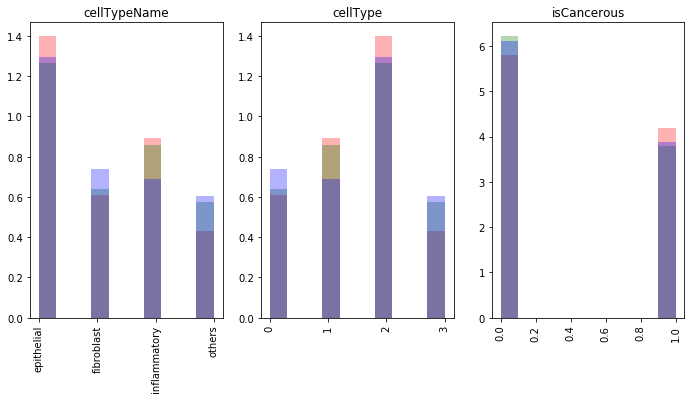

In [535]:
# plt.figure(figsize=(20,20))
# for i, col in enumerate(train_data.columns):
#     plt.subplot(4,5,i+1)
#     _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
#     _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
#     plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
#     plt.title(col)
#     plt.xticks(rotation='vertical')

plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
    _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

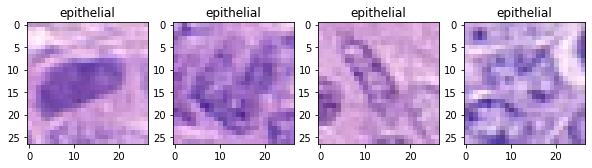

In [536]:
from PIL import Image

label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['cellType']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [537]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


# Model Development
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

I'll start with the 2nd point first - Classify images according to cell-type

### Initializing the model

In [538]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Mock Base Model
Just playing around, based on week 9 QnA + Lab (both pretty much the same)

In [539]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [540]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [541]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


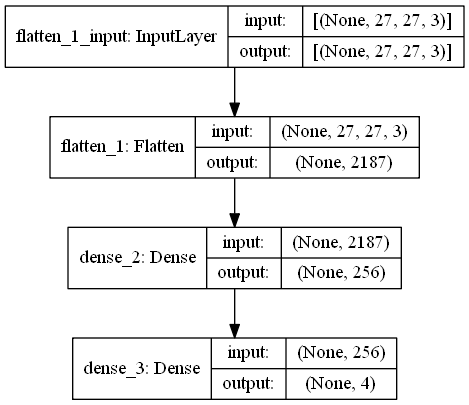

In [542]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [543]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### Training the Model

In [544]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [545]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [546]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

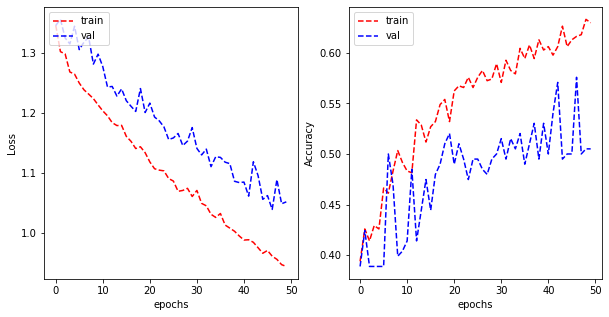

In [547]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [548]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [549]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [550]:
history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

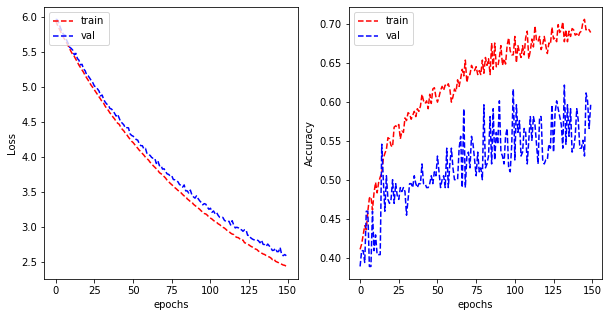

In [551]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Dropout

In [552]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [553]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [554]:
history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

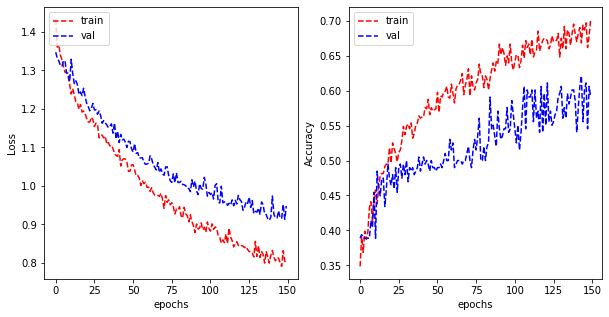

In [555]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Using keras-tuner to tune the model

In [556]:
!pip install -q -U keras-tuner

In [557]:
import kerastuner as kt

In [558]:
from tensorflow import keras
from tensorflow.keras import layers

INPUT_DIM = (27,27,3)
# We will be tuning HIDDEN_LAYER_DIM as hp_units
# HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

# copy pasted from https://www.tensorflow.org/tutorials/keras/keras_tuner, will need to paraphrase
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=INPUT_DIM))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(OUTPUT_CLASSES))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])



  return model

In [559]:
# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

### Saving the models created

In [560]:
# Original model without tuning
model.save("base_model")

# Model with regularization
model_reg.save("reg_base_model")

# Model with dropout
model_drop.save("dropout_base_model")

INFO:tensorflow:Assets written to: base_model\assets
INFO:tensorflow:Assets written to: reg_base_model\assets
INFO:tensorflow:Assets written to: dropout_base_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [355]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 4 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [356]:
model_drop.evaluate(test_generator)

198/198 [==============================] - 0s 1ms/step - loss: 0.9149 - categorical_accuracy: 0.6616


[0.9148502349853516, 0.6616161465644836]

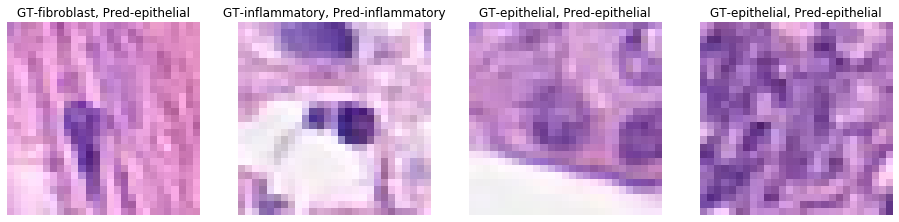

In [357]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Mock 2nd Model (leNet)
Based on week 10 QnA (week 10 lab uses VGG)

In [358]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [359]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [360]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

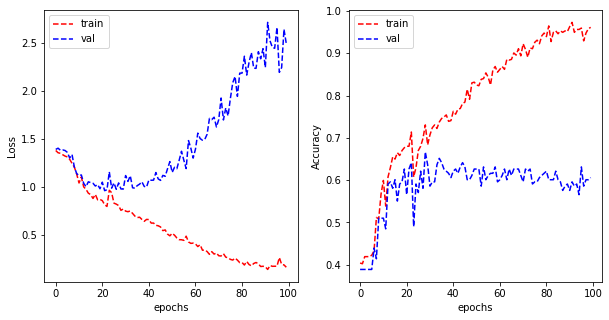

In [361]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Data Augmentation/Tuning for leNet model
TODO

# Mock 3rd Model (VGG)
Based on week 10 lab

In [362]:
import tensorflow as tf

OUTPUT_CLASSES = 4
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [363]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [364]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

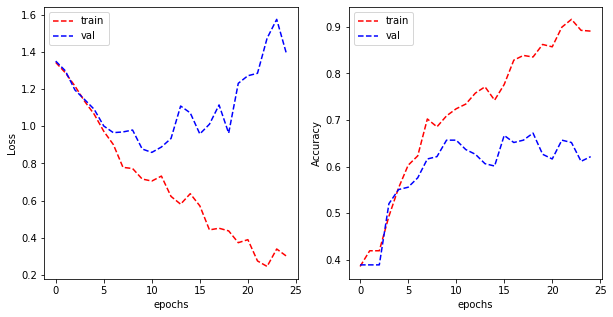

In [365]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Data Augmentation/Tuning for VGG model
TODO

# Model Development part 2
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

Now I'll do the detecting cancerous cell of the assignment

### EDA

In [561]:
train_data.cellTypeName.unique()

array(['epithelial', 'fibroblast', 'inflammatory', 'others'], dtype=object)

Since there is 4 cell type and 2 isCancerous type, the number of label that one model has to predict is 8. It is better to have 4 models and each model handling 1 cell type and 2 isCancerous type and predict 2 label than having one model predict 8. 

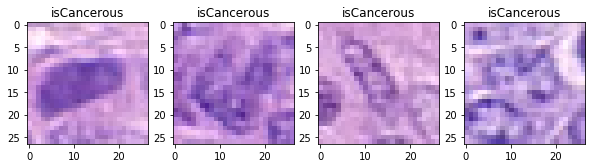

In [562]:
from PIL import Image

label_names = {'isCancerous' : 1, 'notCancerous' : 0}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['isCancerous']
target_list = list(target)

fig = plt.figure(figsize=[10,10])
n = 4
for i in np.arange(n):
    plt.subplot(1, n, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

An interesting revalation occur, apparently cell type fibroblast, inflammatory and other does not have isCancerous lable while cell type epithelial does not have notCancerous label. 

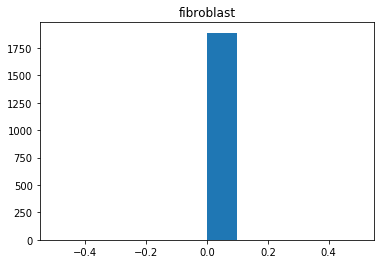

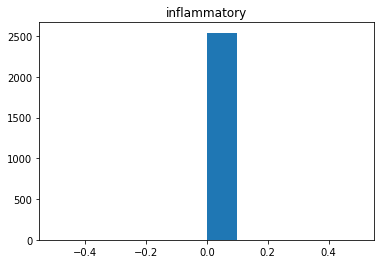

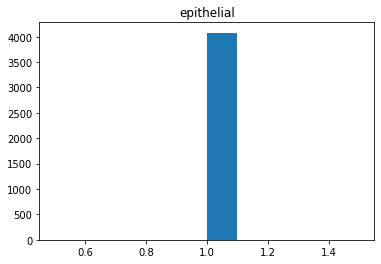

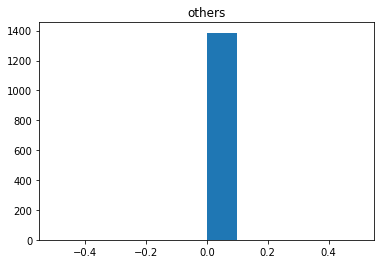

In [563]:

fibroblast = data[data['cellType']==0]
inflammatory = data[data['cellType']==1]
epithelial = data[data['cellType']==2]
others = data[data['cellType']==3]


plt.hist(fibroblast['isCancerous'])
plt.title('fibroblast')
plt.show()

plt.hist(inflammatory['isCancerous'])
plt.title('inflammatory')
plt.show()

plt.hist(epithelial['isCancerous'])
plt.title('epithelial')
plt.show()

plt.hist(others['isCancerous'])
plt.title('others')
plt.show()

From the observation above, it would not be smart to have 4 models handling each type of cell. Sorry if this contracdict with what I said above but I tried to avoid a "Zero Frequency Probem"

In [564]:
"""
train_data_fibroblast = train_data[train_data['cellType']=='0']
train_data_inflammatory = train_data[train_data['cellType']=='1']
train_data_epithelial = train_data[train_data['cellType']=='2']
train_data_others = train_data[train_data['cellType']=='3']

test_data_fibroblast = test_data[test_data['cellType']=='0']
test_data_inflammatory = test_data[test_data['cellType']=='1']
test_data_epithelial = test_data[test_data['cellType']=='2']
test_data_others = test_data[test_data['cellType']=='3']

val_data_fibroblast = val_data[val_data['cellType']=='0']
val_data_inflammatory = val_data[val_data['cellType']=='1']
val_data_epithelial = val_data[val_data['cellType']=='2']
val_data_others = val_data[val_data['cellType']=='3']
"""

"\ntrain_data_fibroblast = train_data[train_data['cellType']=='0']\ntrain_data_inflammatory = train_data[train_data['cellType']=='1']\ntrain_data_epithelial = train_data[train_data['cellType']=='2']\ntrain_data_others = train_data[train_data['cellType']=='3']\n\ntest_data_fibroblast = test_data[test_data['cellType']=='0']\ntest_data_inflammatory = test_data[test_data['cellType']=='1']\ntest_data_epithelial = test_data[test_data['cellType']=='2']\ntest_data_others = test_data[test_data['cellType']=='3']\n\nval_data_fibroblast = val_data[val_data['cellType']=='0']\nval_data_inflammatory = val_data[val_data['cellType']=='1']\nval_data_epithelial = val_data[val_data['cellType']=='2']\nval_data_others = val_data[val_data['cellType']=='3']\n"

### Training the model

In [565]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [566]:
model_cancer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])


In [567]:
model_cancer.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [568]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [569]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [570]:
history = model_cancer.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

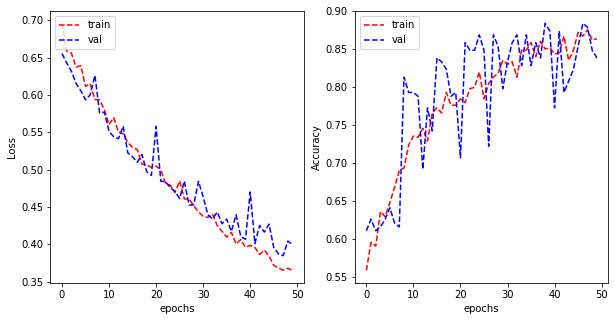

In [571]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [572]:
reg_lambda = 0.06

model_cancer_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [573]:
model_cancer_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [574]:
history_cancer_reg = model_cancer_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

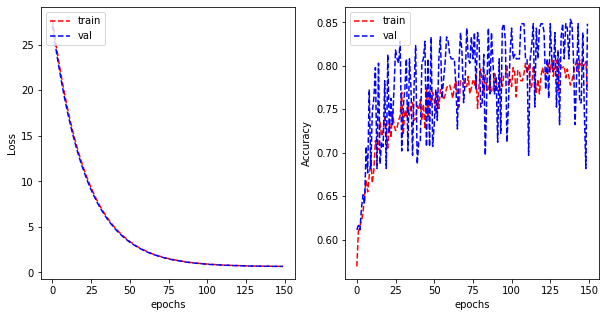

In [575]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_reg.history['loss'], 'r--')
plt.plot(history_cancer_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Drop out

In [576]:
reg_lambda = 0.01

model_cancer_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [577]:
model_cancer_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [578]:
history_cancer_drop = model_cancer_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

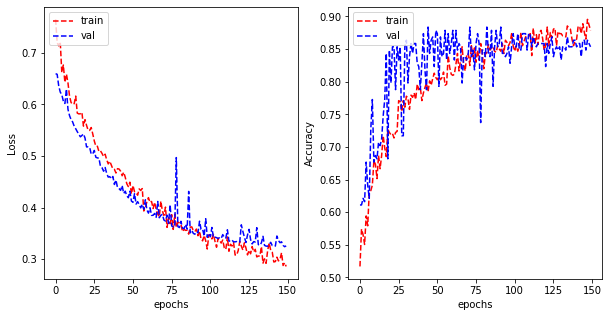

In [579]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_drop.history['loss'], 'r--')
plt.plot(history_cancer_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Using keras-tuner to tune the model

In [580]:
INPUT_DIM = (27,27,3)
# We will be tuning HIDDEN_LAYER_DIM as hp_units
# HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

# copy pasted from https://www.tensorflow.org/tutorials/keras/keras_tuner, will need to paraphrase
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=INPUT_DIM))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(OUTPUT_CLASSES))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])



  return model

In [581]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [582]:
# Original model without tuning
model_cancer.save("cancer_base_model")

# Model with regularization
model_cancer_reg.save("cancer_reg_base_model")

# Model with dropout
model_cancer_drop.save("cancer_dropout_base_model")

INFO:tensorflow:Assets written to: cancer_base_model\assets
INFO:tensorflow:Assets written to: cancer_reg_base_model\assets
INFO:tensorflow:Assets written to: cancer_dropout_base_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [583]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 2 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [584]:
model_cancer_drop.evaluate(test_generator)

198/198 [==============================] - 0s 1ms/step - loss: 0.3230 - categorical_accuracy: 0.8586


[0.32301899790763855, 0.8585858345031738]

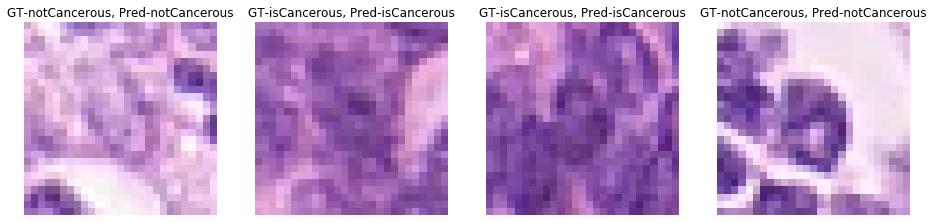

In [585]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_drop.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')